In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.utils import pickle_open
from cohlib.utils import pickle_open
from cohlib.plot import draw_raster_single
from cohlib.sample import sample_spikes_from_xs
from cohlib.alg.em_sgc import deconstruct_Gamma_full_real

In [2]:
def Gamma_est_from_zs(zs, dc=False):
    if dc is True:
        zs_outer = np.einsum('ijk,imk->kjmi', zs[:,:,1:], zs[:,:,1:].conj())
    else:
        zs_outer = np.einsum('ijk,imk->kjmi', zs, zs.conj())
    zs_outer_mean = zs_outer.mean(3)
    return zs_outer_mean

def cif_alpha_loglink(alphas, xs):
    pre_lam = alphas[None,:,None] + xs
    return np.exp(pre_lam)

from numpy.fft import rfft
from cohlib.mvcn import thr_coherence, estimate_coherence

In [3]:
fs = 1000

win=1000
L=50
K=2

sample_length = win
em_iters = 20
alpha = 4.0
alpha = float(alpha)
init_type = "flat"
optim_type = "BFGS"

# model_path = f'saved/fitted_models/simple_synthetic_logpoisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_fitted'
# model_load = pickle_open(model_path)


data_path = f'saved/synthetic_data/simple_synthetic_logpoisson_fixed_gamma_{K}_{L}_{sample_length}'
data_load = pickle_open(data_path)
latent = data_load['latent']
xs = latent['xs']
alphas = np.array([alpha for k in range(K)])
lams = cif_alpha_loglink(alphas, xs)

Text(0, 0.5, '$\\lambda_t^{k,\\ell}$')

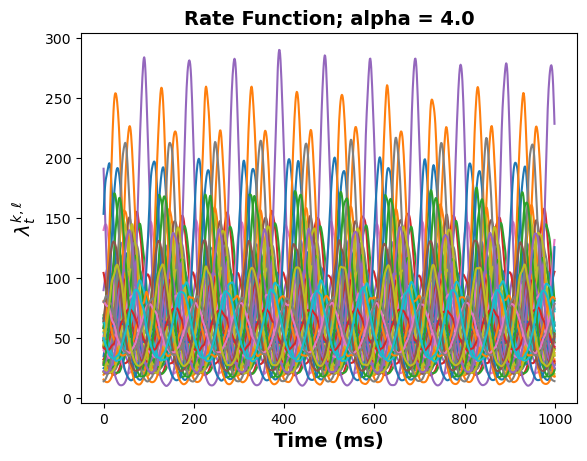

In [4]:
for l in range(L):
    plt.plot(lams[l,0,:])
plt.title(f'Rate Function; alpha = {alpha}', fontweight='bold', fontsize=14)
plt.xlabel('Time (ms)', fontweight='bold', fontsize=14)
plt.ylabel(r'$\lambda_t^{k,\ell}$', fontweight='bold', fontsize=14)

In [5]:
from cohlib.alg.em_sgc import construct_Gamma_full_real
from cohlib.alg.em_sgc import deconstruct_Gamma_full_real
def get_alpha_data(alpha, logS, link, init_type, optim_type, track=None):
    fs = 1000
    seed = 8

    win=1000
    L=50
    C=1
    emiter=25
    K=2

    alpha=float(alpha)

    sample_length = win
    em_iters = emiter

    data_path = f'saved/synthetic_data/simple_synthetic_{link}poisson_fixed_gamma_{K}_{L}_{sample_length}'
    data_load = pickle_open(data_path)
    latent = data_load['latent']
    Gamma = latent['Gamma']
    zs = latent['zs']
    xs = latent['xs']




    # obs = data_load['observed']
    alphas = np.array([alpha for k in range(K)])

    lams = cif_alpha_loglink(alphas, xs)
    spikes = sample_spikes_from_xs(lams, C, delta=1/fs, obs_model='poisson')
    Gamma_zest = Gamma_est_from_zs(zs)



    spikes_mc = spikes.mean(1)
    # ft_spikes = rfft(spikes_mc*(fs/(2*np.pi)), axis=2, norm='backward')
    ft_spikes = rfft(spikes_mc, axis=2, norm='backward')
    S_naive = (ft_spikes * ft_spikes.conj()).mean((0)).real
    S_naive = S_naive[0,1:51]

    ft_spikes0 = ft_spikes[:,0,1:]
    ft_spikes1 = ft_spikes[:,1,1:]

    model_path = f'saved/fitted_models/simple_synthetic_{link}poisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted'
    # if link == "relu":
    #     model_path = f'saved/fitted_models/simple_synthetic_deltarelupoisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_fitted'
    # elif link == 'id':
    # else:
    #     raise ValueError

    model_load = pickle_open(model_path)
    num_J_vars = int(model_load['Gamma'].shape[0]*2)
    Gamma_init = deconstruct_Gamma_full_real(model_load['inv_init'], K, num_J_vars, invert=True)

    S_true = Gamma[:50,0,0].real
    S_oracle = Gamma_zest[:50,0,0].real
    S_init = Gamma_init[:50,0,0].real

    coh_naive = estimate_coherence(ft_spikes0, ft_spikes1)
    coh_naive = coh_naive[:50]
    coh_true = thr_coherence(Gamma[:50,:,:])
    coh_oracle = thr_coherence(Gamma_zest[:50,:,:])
    coh_init = thr_coherence(Gamma_init[:50,:,:])


    if logS is True:
        S_true = 10*np.log10(S_true)
        S_naive = 10*np.log10(S_naive)
        S_oracle = 10*np.log10(S_oracle)
        S_init = 10*np.log10(S_init)

    if track is not None:
        S_model = []
        coh_model = []

        for e in range(track[0], track[1]):
            Gamma_est_itr = model_load['track'][0][e]['gamma']
            S_model_itr = Gamma_est_itr[:50,0,0].real
            coh_model_itr = thr_coherence(Gamma_est_itr[:50,:,:])
            if logS is True:
                S_model_itr = 10*np.log10(S_model_itr)

            S_model.append(S_model_itr)
            coh_model.append(coh_model_itr)

    else:
        Gamma_est = model_load['Gamma']
        S_model = Gamma_est[:50,0,0].real
        coh_model = thr_coherence(Gamma_est[:50,:,:])
        if logS is True:
            S_model = 10*np.log10(S_model)


    S_dict = dict(true=S_true, oracle=S_oracle, model=S_model, naive=S_naive, init=S_init)
    coh_dict = dict(true=coh_true, oracle=coh_oracle, model=coh_model, naive=coh_naive, init=coh_init)

    return dict(coh=coh_dict, S=S_dict)



4.0


Text(0.5, 0, 'Freq (Hz)')

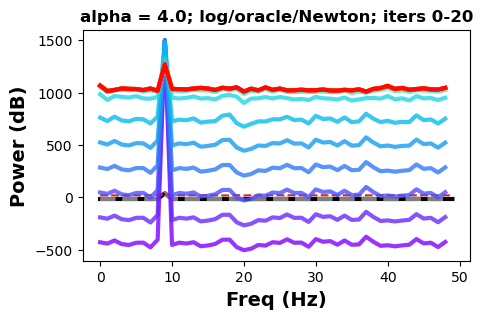

In [6]:
link = "log"
init_type = "oracle"
optim_type = "Newton"
alpha = 4.0
delta = 1

fig, ax = plt.subplots(figsize=(5,3))
i = 0

track = np.array([0,20])
track += 0



print(alpha)
logS = True
alpha_dict = get_alpha_data(alpha, logS, link, init_type, optim_type, track=track)
S_true = alpha_dict['S']['true']
S_oracle = alpha_dict['S']['oracle']
S_naive = alpha_dict['S']['naive']
S_init = alpha_dict['S']['init']


# coh_true = alpha_dict['coh']['true']
# coh_oracle = alpha_dict['coh']['oracle']
# coh_model = alpha_dict['coh']['model']
# coh_naive = alpha_dict['coh']['naive']

ax.plot(S_true, color='k', label='true', linewidth=3)
ax.plot(S_init, '--', color='tab:grey', label='init', linewidth=3)
# ax.plot(S_oracle, color='tab:green', label='direct')
ax.plot(S_naive, linestyle='--', color='tab:red', label='naive')


if track is None:
    S_model = alpha_dict['S']['model']
    ax.plot(S_model, color='tab:blue', linewidth=3, label='model')
    ax.set_title(f'alpha = {alpha}', fontweight='bold', fontsize=14)
else:
    S_model_list = alpha_dict['S']['model']
    color = plt.cm.rainbow(np.linspace(0, 1, len(S_model_list)))
    # for i, c in enumerate(color):
    # plt.plot(x, y, c=c)
    for e, c in enumerate(color): 
        ax.plot(S_model_list[e]*(delta**2*(2*np.pi)**2), color=c, linewidth=3, alpha=0.8)
    ax.set_title(f'alpha = {alpha}; {link}/{init_type}/{optim_type}; iters {track[0]}-{track[1]}', fontweight='bold', fontsize=12)

if logS is False:
    ax.set_ylabel(f'Power', fontweight='bold', fontsize=14)
else:
    ax.set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
ax.set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
# if k == 3:
    # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
    # ax[i1,i2].set_ylim([low, 1])
# ax.set_ylim([1e4,1e8])

4.0
4.0
4.0
4.0


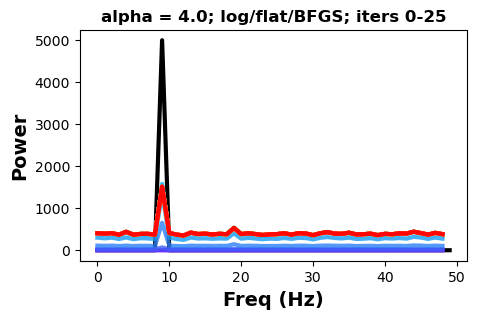

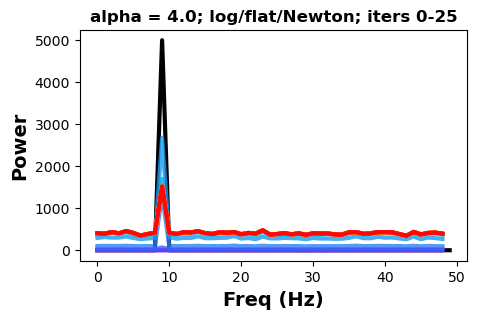

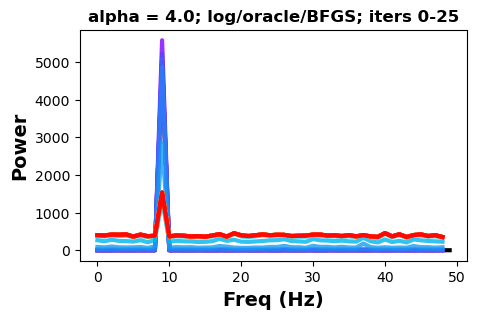

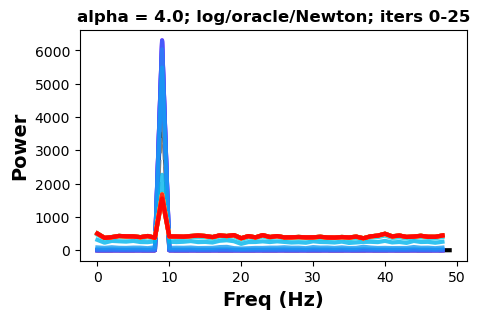

In [7]:
logS = False
alpha = 4.0
for init_type in ["flat", "oracle"]:
    for optim_type in ["BFGS", "Newton"]:
        for link in ["log"]:
            fig, ax = plt.subplots(figsize=(5,3))
            i = 0

            track = np.array([0,25])
            track += 0



            print(alpha)
            alpha_dict = get_alpha_data(alpha, logS, link, init_type, optim_type, track=track)
            S_true = alpha_dict['S']['true']
            S_oracle = alpha_dict['S']['oracle']
            S_naive = alpha_dict['S']['naive']
            S_init = alpha_dict['S']['init']


            # coh_true = alpha_dict['coh']['true']
            # coh_oracle = alpha_dict['coh']['oracle']
            # coh_model = alpha_dict['coh']['model']
            # coh_naive = alpha_dict['coh']['naive']

            ax.plot(S_true, color='k', label='true', linewidth=3)
            ax.plot(S_init, '--', color='tab:grey', label='init', linewidth=3)
            # ax.plot(S_oracle, color='tab:green', label='direct')
            # ax.plot(S_naive, linestyle='--', color='tab:red', label='naive')


            if track is None:
                S_model = alpha_dict['S']['model']
                ax.plot(S_model, color='tab:blue', linewidth=3, label='model')
                ax.set_title(f'alpha = {alpha}', fontweight='bold', fontsize=14)
            else:
                S_model_list = alpha_dict['S']['model']
                color = plt.cm.rainbow(np.linspace(0, 1, len(S_model_list)))
                # for i, c in enumerate(color):
                # plt.plot(x, y, c=c)
                for e, c in enumerate(color): 
                    ax.plot(S_model_list[e], color=c, linewidth=3, alpha=0.8)
                ax.set_title(f'alpha = {alpha}; {link}/{init_type}/{optim_type}; iters {track[0]}-{track[1]}', fontweight='bold', fontsize=12)

            if logS is False:
                ax.set_ylabel(f'Power', fontweight='bold', fontsize=14)
            else:
                ax.set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
            ax.set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
            # if k == 3:
                # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
                # ax[i1,i2].set_ylim([low, 1])
            # ax.set_ylim([1e4,1e8])

4.0
4.0
4.0
4.0


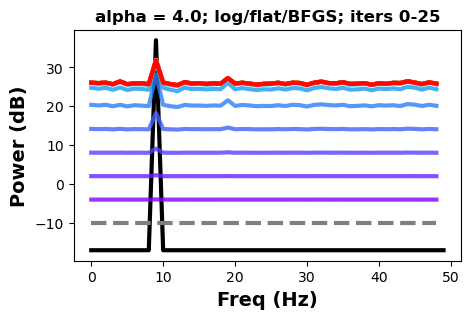

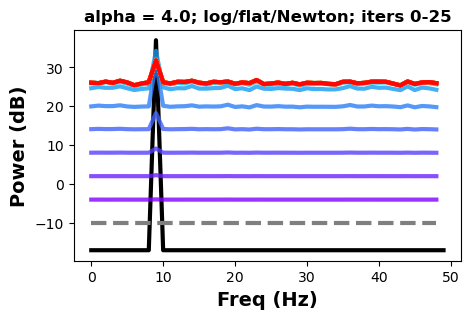

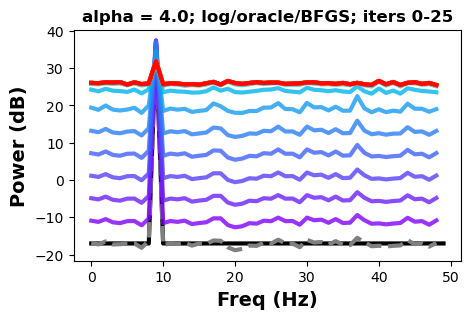

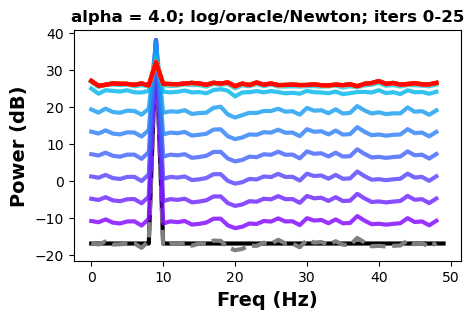

In [8]:
logS = True
alpha = 4.0
for init_type in ["flat", "oracle"]:
    for optim_type in ["BFGS", "Newton"]:
        for link in ["log"]:
            fig, ax = plt.subplots(figsize=(5,3))
            i = 0

            track = np.array([0,25])
            track += 0



            print(alpha)
            alpha_dict = get_alpha_data(alpha, logS, link, init_type, optim_type, track=track)
            S_true = alpha_dict['S']['true']
            S_oracle = alpha_dict['S']['oracle']
            S_naive = alpha_dict['S']['naive']
            S_init = alpha_dict['S']['init']


            # coh_true = alpha_dict['coh']['true']
            # coh_oracle = alpha_dict['coh']['oracle']
            # coh_model = alpha_dict['coh']['model']
            # coh_naive = alpha_dict['coh']['naive']

            ax.plot(S_true, color='k', label='true', linewidth=3)
            ax.plot(S_init, '--', color='tab:grey', label='init', linewidth=3)
            # ax.plot(S_oracle, color='tab:green', label='direct')
            # ax.plot(S_naive, linestyle='--', color='tab:red', label='naive')


            if track is None:
                S_model = alpha_dict['S']['model']
                ax.plot(S_model, color='tab:blue', linewidth=3, label='model')
                ax.set_title(f'alpha = {alpha}', fontweight='bold', fontsize=14)
            else:
                S_model_list = alpha_dict['S']['model']
                color = plt.cm.rainbow(np.linspace(0, 1, len(S_model_list)))
                # for i, c in enumerate(color):
                # plt.plot(x, y, c=c)
                for e, c in enumerate(color): 
                    ax.plot(S_model_list[e], color=c, linewidth=3, alpha=0.8)
                ax.set_title(f'alpha = {alpha}; {link}/{init_type}/{optim_type}; iters {track[0]}-{track[1]}', fontweight='bold', fontsize=12)

            if logS is False:
                ax.set_ylabel(f'Power', fontweight='bold', fontsize=14)
            else:
                ax.set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
            ax.set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
            # if k == 3:
                # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
                # ax[i1,i2].set_ylim([low, 1])
            # ax.set_ylim([1e4,1e8])

200
200
200
200
200
200
200
200


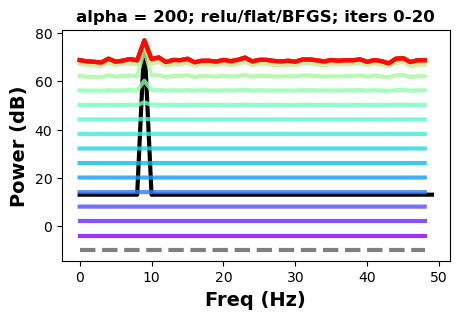

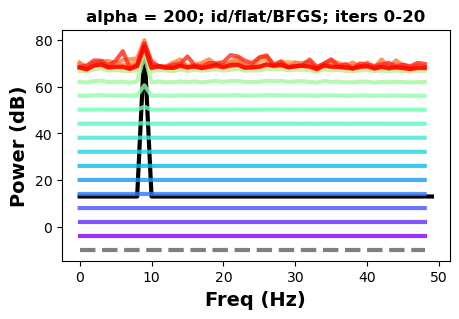

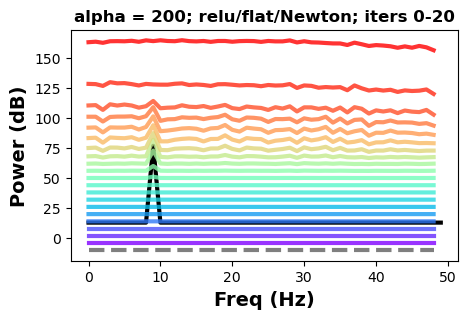

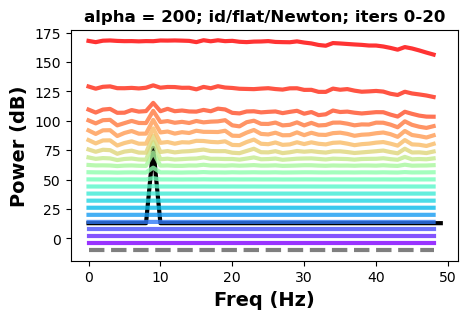

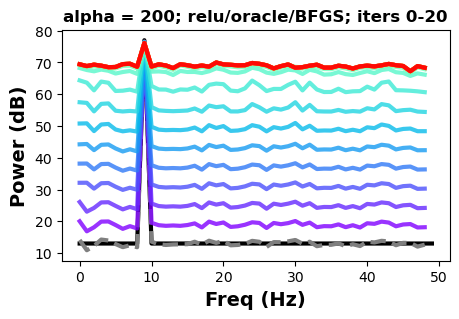

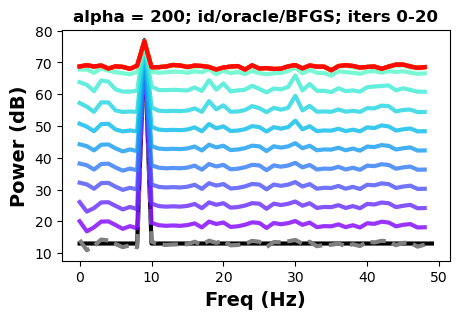

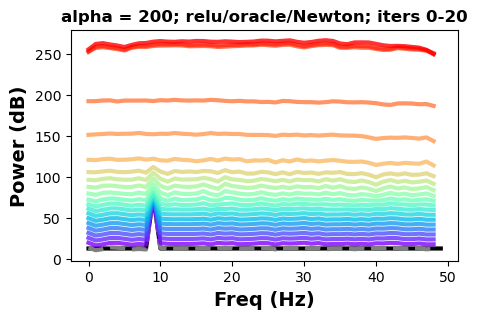

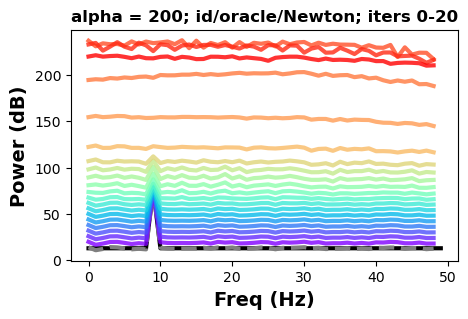

In [63]:
alpha = 200
for init_type in ["flat", "oracle"]:
    for optim_type in ["BFGS", "Newton"]:
        for link in ["relu", "id"]:
            fig, ax = plt.subplots(figsize=(5,3))
            i = 0

            track = np.array([0,20])
            track += 0



            print(alpha)
            logS = True
            alpha_dict = get_alpha_data(alpha, logS, link, init_type, optim_type, track=track)
            S_true = alpha_dict['S']['true']
            S_oracle = alpha_dict['S']['oracle']
            S_naive = alpha_dict['S']['naive']
            S_init = alpha_dict['S']['init']


            # coh_true = alpha_dict['coh']['true']
            # coh_oracle = alpha_dict['coh']['oracle']
            # coh_model = alpha_dict['coh']['model']
            # coh_naive = alpha_dict['coh']['naive']

            ax.plot(S_true, color='k', label='true', linewidth=3)
            ax.plot(S_init, '--', color='tab:grey', label='init', linewidth=3)
            # ax.plot(S_oracle, color='tab:green', label='direct')
            # ax.plot(S_naive, linestyle='--', color='tab:red', label='naive')


            if track is None:
                S_model = alpha_dict['S']['model']
                ax.plot(S_model, color='tab:blue', linewidth=3, label='model')
                ax.set_title(f'alpha = {alpha}', fontweight='bold', fontsize=14)
            else:
                S_model_list = alpha_dict['S']['model']
                color = plt.cm.rainbow(np.linspace(0, 1, len(S_model_list)))
                # for i, c in enumerate(color):
                # plt.plot(x, y, c=c)
                for e, c in enumerate(color): 
                    ax.plot(S_model_list[e], color=c, linewidth=3, alpha=0.8)
                ax.set_title(f'alpha = {alpha}; {link}/{init_type}/{optim_type}; iters {track[0]}-{track[1]}', fontweight='bold', fontsize=12)

            if logS is False:
                ax.set_ylabel(f'Power', fontweight='bold', fontsize=14)
            else:
                ax.set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
            ax.set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
            # if k == 3:
                # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
                # ax[i1,i2].set_ylim([low, 1])
            # ax.set_ylim([1e4,1e8])

500
500
500
500
500
500
500
500


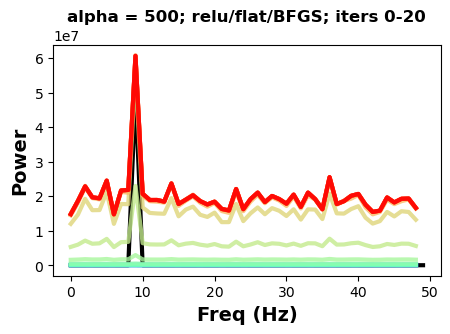

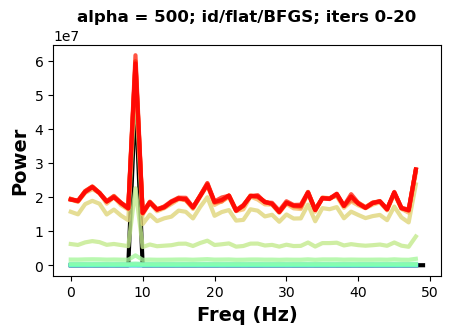

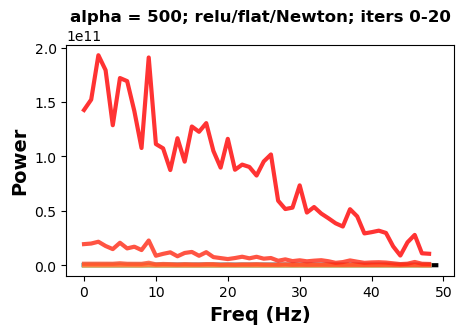

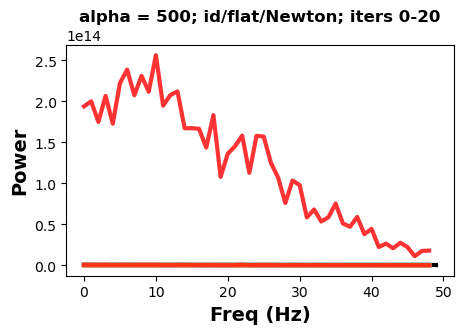

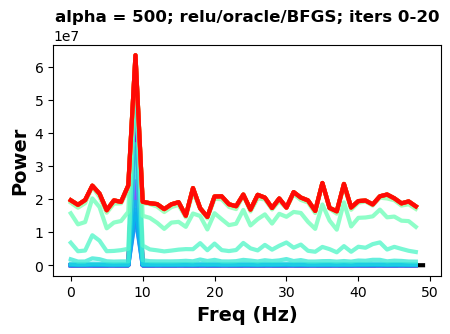

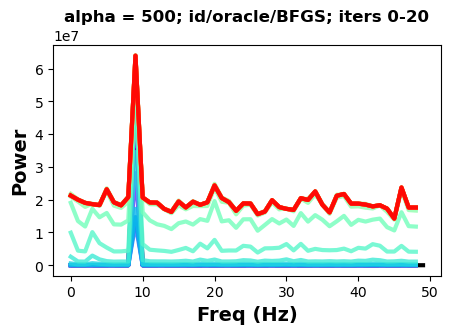

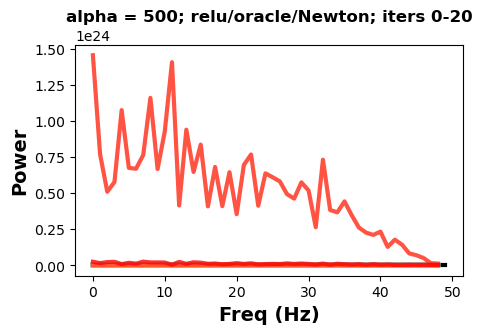

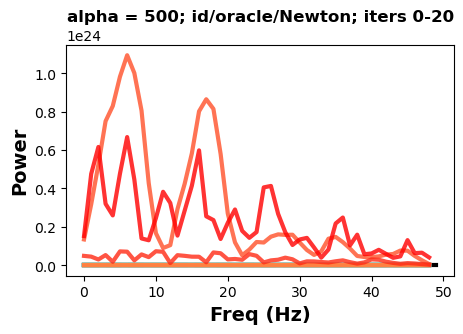

In [137]:
alpha = 500
for init_type in ["flat", "oracle"]:
    for optim_type in ["BFGS", "Newton"]:
        for link in ["relu", "id"]:
            fig, ax = plt.subplots(figsize=(5,3))
            i = 0

            track = np.array([0,20])
            track += 0



            print(alpha)
            logS = False
            alpha_dict = get_alpha_data(alpha, logS, link, init_type, optim_type, track=track)
            S_true = alpha_dict['S']['true']
            S_oracle = alpha_dict['S']['oracle']
            S_naive = alpha_dict['S']['naive']
            S_init = alpha_dict['S']['init']


            # coh_true = alpha_dict['coh']['true']
            # coh_oracle = alpha_dict['coh']['oracle']
            # coh_model = alpha_dict['coh']['model']
            # coh_naive = alpha_dict['coh']['naive']

            ax.plot(S_true, color='k', label='true', linewidth=3)
            ax.plot(S_init, '--', color='tab:grey', label='init', linewidth=3)
            # ax.plot(S_oracle, color='tab:green', label='direct')
            # ax.plot(S_naive, linestyle='--', color='tab:red', label='naive')


            if track is None:
                S_model = alpha_dict['S']['model']
                ax.plot(S_model, color='tab:blue', linewidth=3, label='model')
                ax.set_title(f'alpha = {alpha}', fontweight='bold', fontsize=14)
            else:
                S_model_list = alpha_dict['S']['model']
                color = plt.cm.rainbow(np.linspace(0, 1, len(S_model_list)))
                # for i, c in enumerate(color):
                # plt.plot(x, y, c=c)
                for e, c in enumerate(color): 
                    ax.plot(S_model_list[e], color=c, linewidth=3, alpha=0.8)
                ax.set_title(f'alpha = {alpha}; {link}/{init_type}/{optim_type}; iters {track[0]}-{track[1]}', fontweight='bold', fontsize=12)

            if logS is False:
                ax.set_ylabel(f'Power', fontweight='bold', fontsize=14)
            else:
                ax.set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
            ax.set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
            # if k == 3:
                # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
                # ax[i1,i2].set_ylim([low, 1])
            # ax.set_ylim([1e4,1e8])

1000
1000
1000
1000
1000
1000
1000
1000


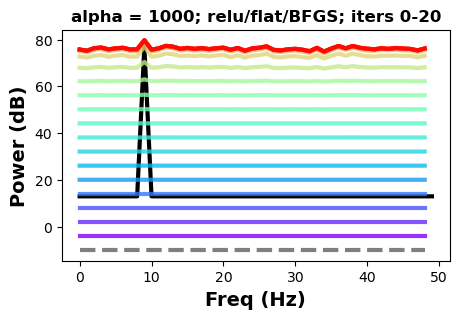

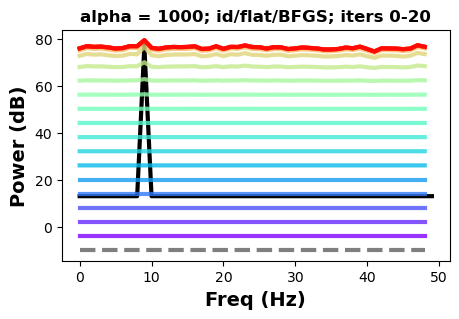

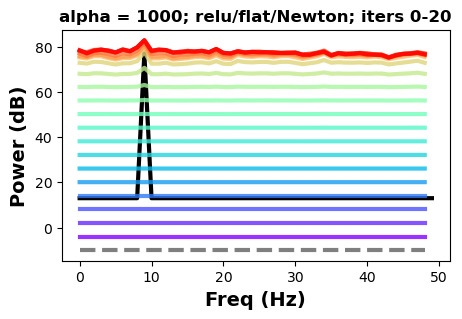

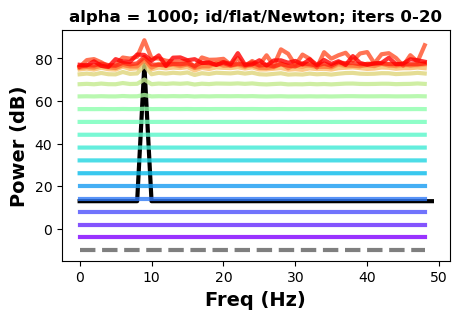

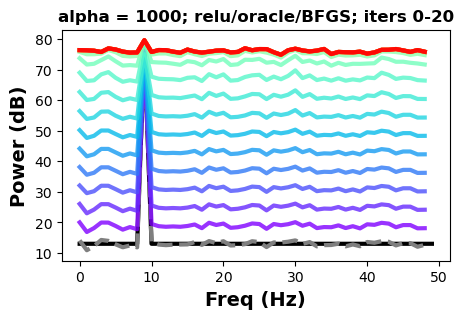

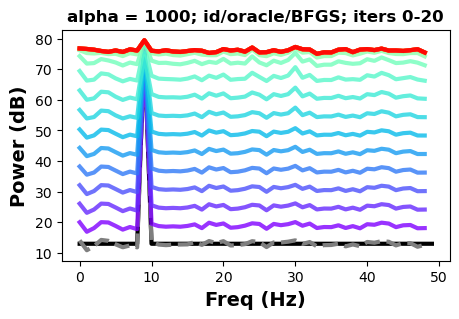

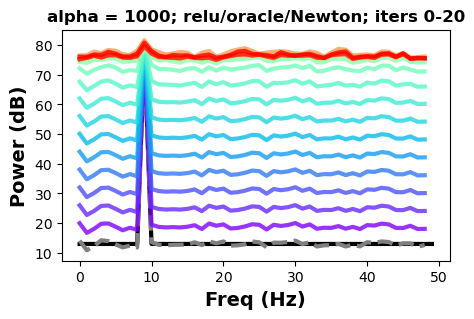

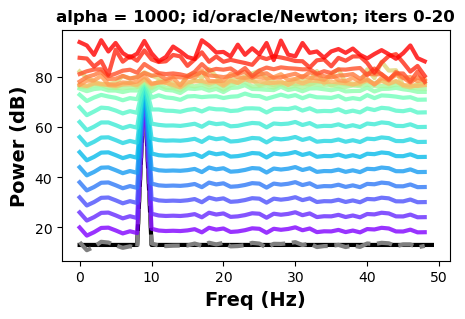

In [65]:

alpha = 1000
for init_type in ["flat", "oracle"]:
    for optim_type in ["BFGS", "Newton"]:
        for link in ["relu", "id"]:
            fig, ax = plt.subplots(figsize=(5,3))
            i = 0

            track = np.array([0,20])
            track += 0



            print(alpha)
            logS = True
            alpha_dict = get_alpha_data(alpha, logS, link, init_type, optim_type, track=track)
            S_true = alpha_dict['S']['true']
            S_oracle = alpha_dict['S']['oracle']
            S_naive = alpha_dict['S']['naive']
            S_init = alpha_dict['S']['init']


            # coh_true = alpha_dict['coh']['true']
            # coh_oracle = alpha_dict['coh']['oracle']
            # coh_model = alpha_dict['coh']['model']
            # coh_naive = alpha_dict['coh']['naive']

            ax.plot(S_true, color='k', label='true', linewidth=3)
            ax.plot(S_init, '--', color='tab:grey', label='init', linewidth=3)
            # ax.plot(S_oracle, color='tab:green', label='direct')
            # ax.plot(S_naive, linestyle='--', color='tab:red', label='naive')


            if track is None:
                S_model = alpha_dict['S']['model']
                ax.plot(S_model, color='tab:blue', linewidth=3, label='model')
                ax.set_title(f'alpha = {alpha}', fontweight='bold', fontsize=14)
            else:
                S_model_list = alpha_dict['S']['model']
                color = plt.cm.rainbow(np.linspace(0, 1, len(S_model_list)))
                # for i, c in enumerate(color):
                # plt.plot(x, y, c=c)
                for e, c in enumerate(color): 
                    ax.plot(S_model_list[e], color=c, linewidth=3, alpha=0.8)
                ax.set_title(f'alpha = {alpha}; {link}/{init_type}/{optim_type}; iters {track[0]}-{track[1]}', fontweight='bold', fontsize=12)

            if logS is False:
                ax.set_ylabel(f'Power', fontweight='bold', fontsize=14)
            else:
                ax.set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
            ax.set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
            # if k == 3:
                # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
                # ax[i1,i2].set_ylim([low, 1])
            # ax.set_ylim([1e4,1e8])

2000


Text(0.5, 0, 'Freq (Hz)')

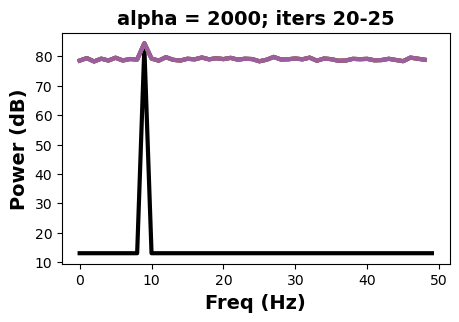

In [12]:
fig, ax = plt.subplots(figsize=(5,3))
alpha = 2000
i = 0

track = np.array([0,5])
track += 20


print(alpha)
logS = True
alpha_dict = get_alpha_data(alpha, logS, track=track)
S_true = alpha_dict['S']['true']
S_oracle = alpha_dict['S']['oracle']
S_naive = alpha_dict['S']['naive']


# coh_true = alpha_dict['coh']['true']
# coh_oracle = alpha_dict['coh']['oracle']
# coh_model = alpha_dict['coh']['model']
# coh_naive = alpha_dict['coh']['naive']

ax.plot(S_true, color='k', label='true', linewidth=3)
# ax.plot(S_oracle, color='tab:green', label='direct')
# ax.plot(S_naive, linestyle='--', color='tab:red', label='naive')

if track is None:
    S_model = alpha_dict['S']['model']
    ax.plot(S_model, color='tab:blue', linewidth=3, label='model')
    ax.set_title(f'alpha = {alpha}', fontweight='bold', fontsize=14)
else:
    S_model_list = alpha_dict['S']['model']
    for e in range(len(S_model_list)):
        ax.plot(S_model_list[e], linewidth=3, alpha=0.8)
    ax.set_title(f'alpha = {alpha}; iters {track[0]}-{track[1]}', fontweight='bold', fontsize=14)

if logS is False:
    ax.set_ylabel(f'Power', fontweight='bold', fontsize=14)
else:
    ax.set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
ax.set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
# if k == 3:
    # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
    # ax[i1,i2].set_ylim([low, 1])
# ax.set_ylim([1e4,1e8])

In [34]:
len(S_model_list)

5

In [28]:
len(S_model_list)

14

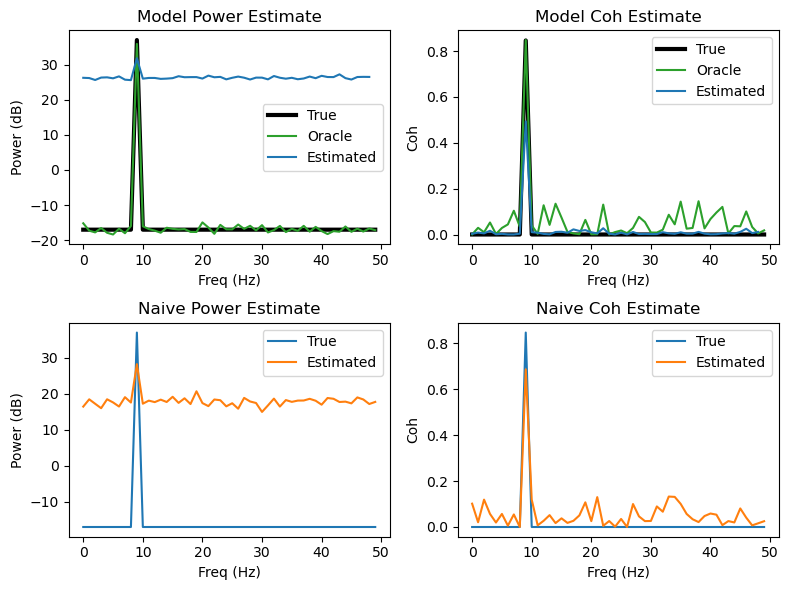

In [11]:
alphas = [2.5, 3.0, 3.5, 4.0, 4.5]

logS = True
alpha_dict = get_alpha_data(alpha, logS)
S_true = alpha_dict['S']['true']
S_oracle = alpha_dict['S']['oracle']
S_model = alpha_dict['S']['model']
S_naive = alpha_dict['S']['naive']

coh_true = alpha_dict['coh']['true']
coh_oracle = alpha_dict['coh']['oracle']
coh_model = alpha_dict['coh']['model']
coh_naive = alpha_dict['coh']['naive']

fig, ax = plt.subplots(2,2, figsize=(8,6))
ax[0,0].plot(S_true, label='True', color='k', linewidth=3)
ax[0,0].plot(S_oracle, label='Oracle', color='tab:green')
ax[0,0].plot(S_model, label='Estimated')
ax[0,0].set_xlabel('Freq (Hz)')
ax[0,0].set_title('Model Power Estimate')
ax[0,1].plot(coh_true, label='True', color='k', linewidth=3)
ax[0,1].plot(coh_oracle, label='Oracle', color='tab:green')
ax[0,1].plot(coh_model, label='Estimated')
ax[0,1].set_ylabel('Coh')
ax[0,1].set_xlabel('Freq (Hz)')
ax[0,1].set_title('Model Coh Estimate')
ax[0,0].legend()
ax[0,1].legend()

ax[1,0].plot(S_true, label='True')
ax[1,0].plot(S_naive[0,:], label='Estimated')
ax[1,0].set_xlabel('Freq (Hz)')
ax[1,0].set_title('Naive Power Estimate')
ax[1,1].plot(coh_true , label='True')
ax[1,1].plot(coh_naive, label='Estimated')
ax[1,1].set_ylabel('Coh')
ax[1,1].set_xlabel('Freq (Hz)')
ax[1,1].set_title('Naive Coh Estimate')
ax[1,0].legend()
ax[1,1].legend()

if logS is True:
    ax[0,0].set_ylabel('Power (dB)')
    ax[1,0].set_ylabel('Power (dB)')
else:
    ax[0,0].set_ylabel('Power')
    ax[1,0].set_ylabel('Power')
plt.tight_layout()

Text(0.5, 1.0, 'Firing Rates')

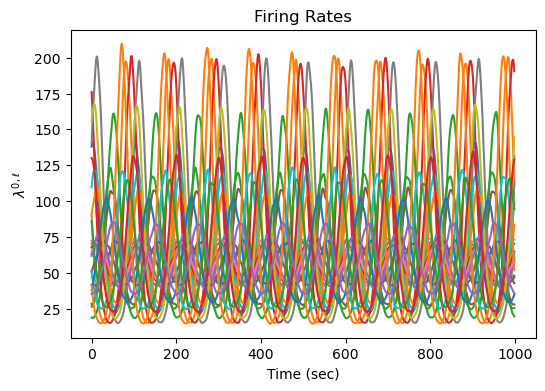

In [12]:
time = np.arange(1000)*1e-3
lams.shape
fig, ax = plt.subplots(figsize=(6,4))
for l in range(L):
    ax.plot(lams[l,0,:])
ax.set_xlabel('Time (sec)')
ax.set_ylabel(r'$\lambda^{0,\ell}$')
ax.set_title('Firing Rates')


In [13]:
from numpy.fft import rfft
from cohlib.mvcn import thr_coherence, estimate_coherence
# spikes_mc = (spikes[:L,:C,0,:] - spikes[:L,:C,0,:].mean(2)[:,:,None]).mean(1)
# spikes_mc = spikes
spikes_mc = spikes.mean(1)
# ft_spikes = rfft(spikes_mc*(fs/(2*np.pi)), axis=2, norm='backward')
ft_spikes = rfft(spikes_mc, axis=2, norm='backward')
S_naive = (ft_spikes * ft_spikes.conj()).mean((0)).real
S_naive = S_naive[:,1:51]

ft_spikes0 = ft_spikes[:,0,1:]
ft_spikes1 = ft_spikes[:,1,1:]

coh_naive = estimate_coherence(ft_spikes0, ft_spikes1)
coh_naive = coh_naive[:50]

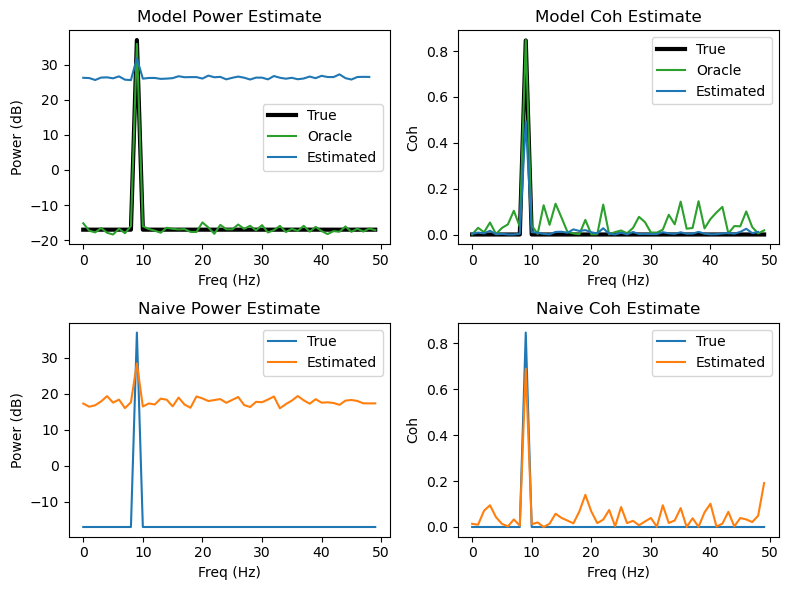

In [14]:
coh_true = thr_coherence(Gamma[:50,:,:])
coh_model = thr_coherence(Gamma_est[:50,:,:])
coh_oracle = thr_coherence(Gamma_zest[:50,:,:])

S_true = Gamma[:50,0,0].real
S_model = Gamma_est[:50,0,0].real
S_oracle = Gamma_zest[:50,0,0].real

logS = True

if logS is True:
    S_true = 10*np.log10(S_true)
    S_model = 10*np.log10(S_model)
    S_naive = 10*np.log10(S_naive)
    S_oracle = 10*np.log10(S_oracle)

fig, ax = plt.subplots(2,2, figsize=(8,6))
ax[0,0].plot(S_true, label='True', color='k', linewidth=3)
ax[0,0].plot(S_oracle, label='Oracle', color='tab:green')
ax[0,0].plot(S_model, label='Estimated')
ax[0,0].set_xlabel('Freq (Hz)')
ax[0,0].set_title('Model Power Estimate')
ax[0,1].plot(coh_true, label='True', color='k', linewidth=3)
ax[0,1].plot(coh_oracle, label='Oracle', color='tab:green')
ax[0,1].plot(coh_model, label='Estimated')
ax[0,1].set_ylabel('Coh')
ax[0,1].set_xlabel('Freq (Hz)')
ax[0,1].set_title('Model Coh Estimate')
ax[0,0].legend()
ax[0,1].legend()

ax[1,0].plot(S_true, label='True')
ax[1,0].plot(S_naive[0,:], label='Estimated')
ax[1,0].set_xlabel('Freq (Hz)')
ax[1,0].set_title('Naive Power Estimate')
ax[1,1].plot(coh_true , label='True')
ax[1,1].plot(coh_naive, label='Estimated')
ax[1,1].set_ylabel('Coh')
ax[1,1].set_xlabel('Freq (Hz)')
ax[1,1].set_title('Naive Coh Estimate')
ax[1,0].legend()
ax[1,1].legend()

if logS is True:
    ax[0,0].set_ylabel('Power (dB)')
    ax[1,0].set_ylabel('Power (dB)')
else:
    ax[0,0].set_ylabel('Power')
    ax[1,0].set_ylabel('Power')
plt.tight_layout()

In [165]:
freqstrt = 0
freqend = 50
def plot_itrs(itrstart, itrend):
    spikes_mc = spikes.mean(1)
    ft_spikes = rfft(spikes_mc*(fs/(2*np.pi)), axis=2, norm='backward')
    S_naive = (ft_spikes * ft_spikes.conj()).mean((0)).real
    S_naive = S_naive[:,1:51]

    ft_spikes0 = ft_spikes[:,0,1:]
    ft_spikes1 = ft_spikes[:,1,1:]

    coh_naive = estimate_coherence(ft_spikes0, ft_spikes1)
    coh_naive = coh_naive[freqstrt:freqend]
    fig, ax = plt.subplots(2,2, figsize=(6,5))
    # itr = 2
    for i, itr in enumerate(range(itrstart,itrend)):
        # print(i+1)
    # for itr in range(10):
        Gamma_est_itr = model_load['track'][0][itr-1]['gamma']

        S_true = Gamma[freqstrt:freqend,0,0].real
        S_model = Gamma_est_itr[freqstrt:freqend,0,0].real

        coh_true = thr_coherence(Gamma[freqstrt:freqend,:,:])
        coh_model = thr_coherence(Gamma_est_itr[freqstrt:freqend,:,:])

        logS = False

        if logS is True:
            S_true = 10*np.log10(S_true)
            S_model = 10*np.log10(S_model)
            S_naive = 10*np.log10(S_naive)

        if i == 0:
            ax[0,0].plot(S_true, label='True', color='k')
            ax[0,1].plot(coh_true, color='k')
        if i < 10:
            ax[0,0].plot(S_model, label='Estimated')
        else:
            ax[0,0].plot(S_model)
        ax[0,1].plot(coh_model)
        ax[0,0].set_ylabel('Power')
        ax[0,0].set_xlabel('Freq (Hz)')
        ax[0,0].set_title('Model Power Estimate')
        ax[0,1].set_ylabel('Coh')
        ax[0,1].set_xlabel('Freq (Hz)')
        ax[0,1].set_title('Model Coh Estimate')
        ax[0,0].legend()
        # ax[0,1].legend()

    ax[1,0].plot(S_true, label='True', color='k')
    ax[1,0].plot(S_naive[0,:], label='Estimated')
    ax[1,0].set_ylabel('Power')
    ax[1,0].set_xlabel('Freq (Hz)')
    ax[1,0].set_title('Naive Power Estimate')
    ax[1,1].plot(coh_true , label='True', color='k')
    ax[1,1].plot(coh_naive, label='Estimated')
    ax[1,1].set_ylabel('Coh')
    ax[1,1].set_xlabel('Freq (Hz)')
    ax[1,1].set_title('Naive Coh Estimate')
    if itr==0:
        ax[1,0].legend()
        ax[1,1].legend()
    plt.tight_layout()

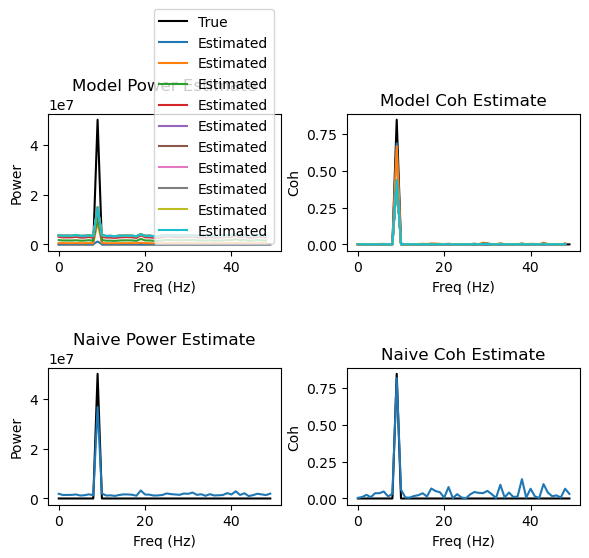

In [166]:
plot_itrs(10,20)

/projectnb/stephenlab/jtauber/cohlib/cohlib/mvcn.py:214: RuntimeWarning: invalid value encountered in divide
  t_coh = num/denom


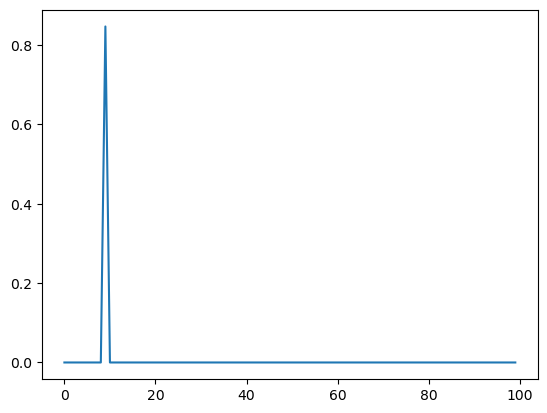

In [19]:
from cohlib.alg.em_sgc import deconstruct_Gamma_full_real
Gamma_inv_init = model_load['inv_init']
J = Gamma_est.shape[0]

Gamma_init = deconstruct_Gamma_full_real(Gamma_inv_init, K, 2*J, invert=True)

# plt.plot(Gamma_init[:,0,0].real)
# plt.plot(Gamma_zest[:50,0,0].real)

In [15]:
Gamma[:,0,0].real

array([5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+07, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
      

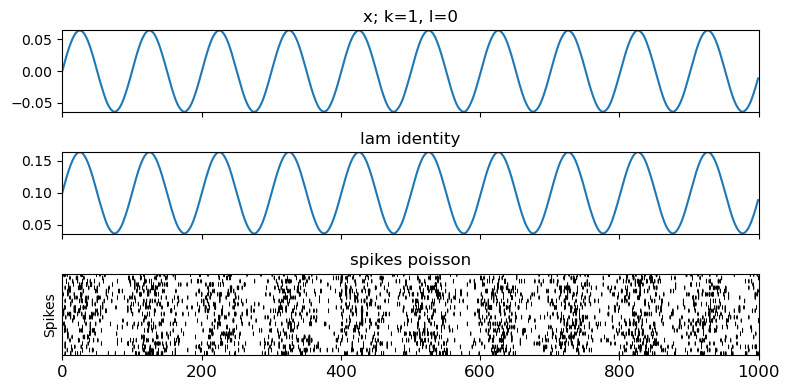

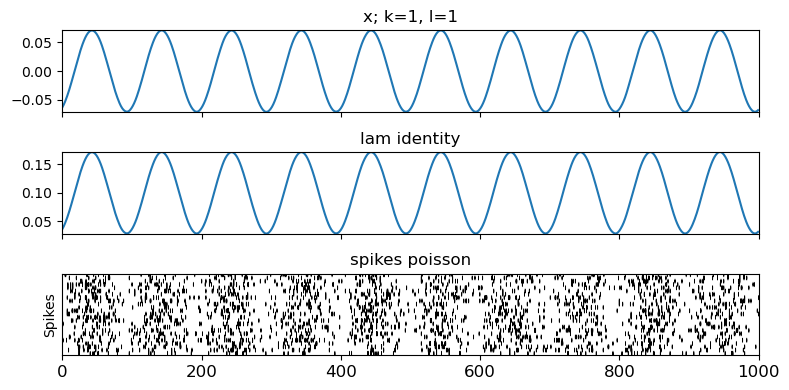

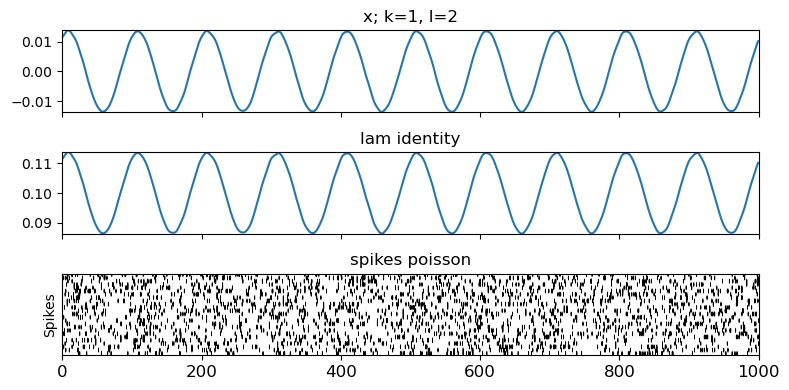

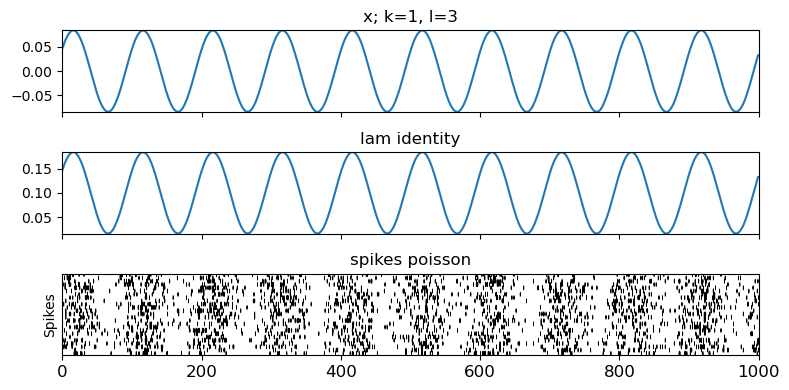

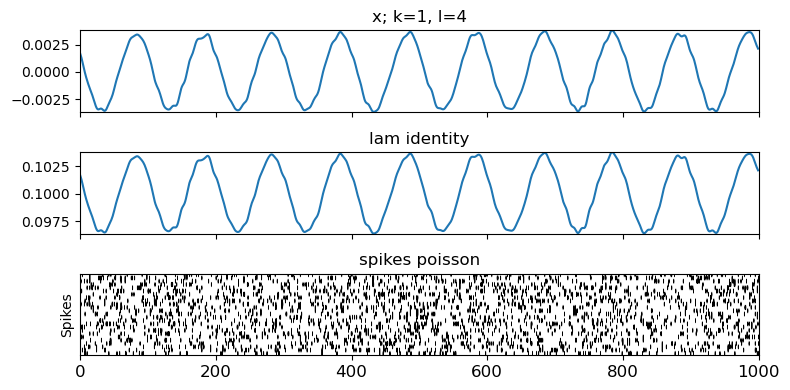

In [98]:
k = 1
l = 0
for l in range(5):
    fig, ax = plt.subplots(3,1,figsize=(8,4), sharex=True)
    ax[0].plot(xs[l,k,:])
    ax[0].set_title(f'x; k={k}, l={l}')
    ax[1].plot(lams[l,k,:])
    ax[1].set_title(f'lam identity')
    draw_raster_single(spikes[l,:,k,:], trange=[0,1000], ax = ax[2])
    ax[2].set_title(f'spikes poisson')
    ax[0].margins(0)
    ax[1].margins(0)

    plt.tight_layout()